In [110]:
library(ggplot2)
library(data.table)
library(viridis)
library(dplyr)
library(RColorBrewer)
library(scales)

library(egg)
library(grid)

# Load megagut metadata

In [2]:
# Metadata from Amanda, cells
meta = fread("/nfs/team205/ao15/Megagut/Annotations_v3/metadata/pooled_healthy.no_doublets.annot_all_levels.updated_donorID.20230126.metadata_update.20230421.csv")

In [3]:
# Clean metadata. Relabel "transverse" => "transverse colon"
meta$organ_unified[meta$organ_unified == "transverse"] = "transverse colon"

In [7]:
# Subset data frame for columns to visualize
select_columns = c("index", "disease", "organ_groups", "study", "donorID_unified", "age_unified", "level_3_annot", "level_1_annot")
meta_sub = meta[, ..select_columns]  # .. is data.table expansion of variable 

In [8]:
head(meta_sub)

index,disease,organ_groups,study,donorID_unified,age_unified,level_3_annot,level_1_annot
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AAACGAATCTCTTGCG-GSM4600896,control,Oral_mucosa,Caetano2021,D61,47-80,EC_venous,Endothelial
AAACGCTAGCGACCCT-GSM4600896,control,Oral_mucosa,Caetano2021,D61,47-80,Mast,Myeloid
AAAGAACAGCGACCCT-GSM4600896,control,Oral_mucosa,Caetano2021,D61,47-80,EC_capillary,Endothelial
AAAGGGCAGTCACACT-GSM4600896,control,Oral_mucosa,Caetano2021,D61,47-80,Mast,Myeloid
AAAGGGCCAACACAGG-GSM4600896,control,Oral_mucosa,Caetano2021,D61,47-80,DC_cDC1,Myeloid
AAAGTCCGTCGAAGCA-GSM4600896,control,Oral_mucosa,Caetano2021,D61,47-80,Mast,Myeloid


In [9]:
#table(meta$organ_groups)

# Count cells and donors per condition
Condition: disease x organ_unified x study

In [10]:
# Count cells per group in selected features of meta_sub
#d_counts = aggregate(index~disease + organ_unified + study + donorID_unified + age_unified, data=d, FUN=length)
d_cell_counts = aggregate(index~., data=meta_sub, FUN=length)

setnames(d_cell_counts, "index", "n_cells")  # rename cell counts column

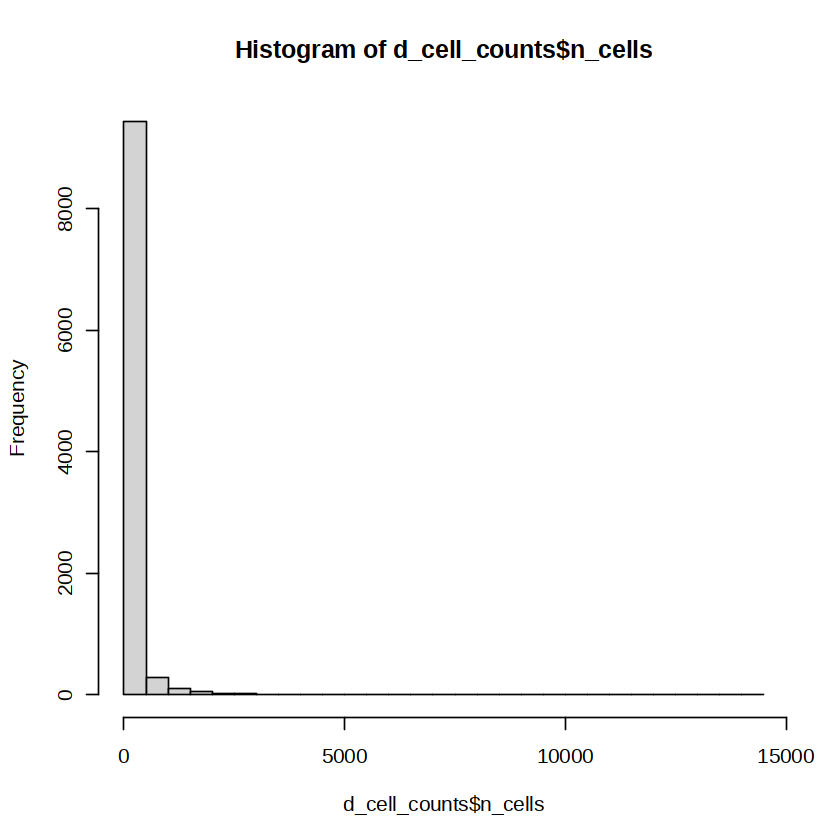

In [11]:
hist(d_cell_counts$n_cells, breaks=50)

In [12]:
head(d_cell_counts)

,disease,organ_groups,study,donorID_unified,age_unified,level_3_annot,level_1_annot,n_cells
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,neighbouring_inflammed,Small_intestine,Martin2019,D39,,B_GC_I,B and B plasma,1
2,neighbouring_inflammed,Small_intestine,Martin2019,D42,,B_GC_I,B and B plasma,7
3,neighbouring_inflammed,Small_intestine,Martin2019,D47,,B_GC_I,B and B plasma,16
4,neighbouring_inflammed,Small_intestine,Martin2019,D48,,B_GC_I,B and B plasma,1
5,inutero,Small_intestine,Elmentaite2021,F10,14-20_second_trimester,B_GC_I,B and B plasma,2
6,inutero,Small_intestine,Elmentaite2021,F12,14-20_second_trimester,B_GC_I,B and B plasma,5


In [108]:
# Count donor sample sizes per condition (organ x study x disease)
d_donor_counts = aggregate(donorID_unified ~ organ_groups + study + level_3_annot, data=d_cell_counts, FUN=length)

setnames(d_donor_counts, "donorID_unified", "n_donor")

# Sum cell count per organ x study x disease
d_condition = aggregate(n_cells ~ organ_groups + study + level_3_annot, data=d_cell_counts, FUN=sum)

# Collect cell and donor counts per organ x study x disease
d_condition = merge(d_donor_counts, d_condition)
head(d_condition)

,organ_groups,study,level_3_annot,n_donor,n_cells
,<chr>,<chr>,<chr>,<int>,<int>
1,Large_intestine,Dominguez2022,B_GC_I,1,1
2,Large_intestine,Dominguez2022,B_memory,2,21
3,Large_intestine,Dominguez2022,B_naive,1,1
4,Large_intestine,Dominguez2022,B_plasma_IgA1,3,117
5,Large_intestine,Dominguez2022,B_plasma_IgA2,1,5
6,Large_intestine,Dominguez2022,B_plasma_IgG,1,2


In [109]:
dim(d_condition)

[1] 2177    5

In [31]:
table(meta$level_1_annot)


B and B plasma    Endothelial     Epithelial    Mesenchymal        Myeloid 
        149240          52804         371724         270956          33213 
        Neural T and NK cells 
         23121         176183 

In [33]:
unique(meta$level_1_annot)

[1] "Endothelial"    "Myeloid"        "Epithelial"     "T and NK cells"
[5] "Mesenchymal"    "B and B plasma" "Neural"

In [47]:
# Get cell types per overall annotation
cell_type_order = lapply(unique(meta$level_1_annot), function(annot) {
    idx = meta$level_1_annot == annot
    #sort(unique(meta$level_3_annot[idx]))  # sort alphabetically
    names(sort(table(meta$level_3_annot[idx]), decreasing=TRUE))  # sort by abundance
})
cell_type_order = rev(unlist(cell_type_order))

In [63]:
# Get list of cell types per lineage
cell_types = lapply(unique(meta$level_1_annot), function(annot) {
    idx = meta$level_1_annot == annot
    unique(meta$level_3_annot[idx])
})
names(cell_types) = unique(meta$level_1_annot)

In [65]:
#cell_types

In [62]:
# order cells by abundance
#cell_type_order = names(sort(table(meta$level_3_annot), decreasing=TRUE))

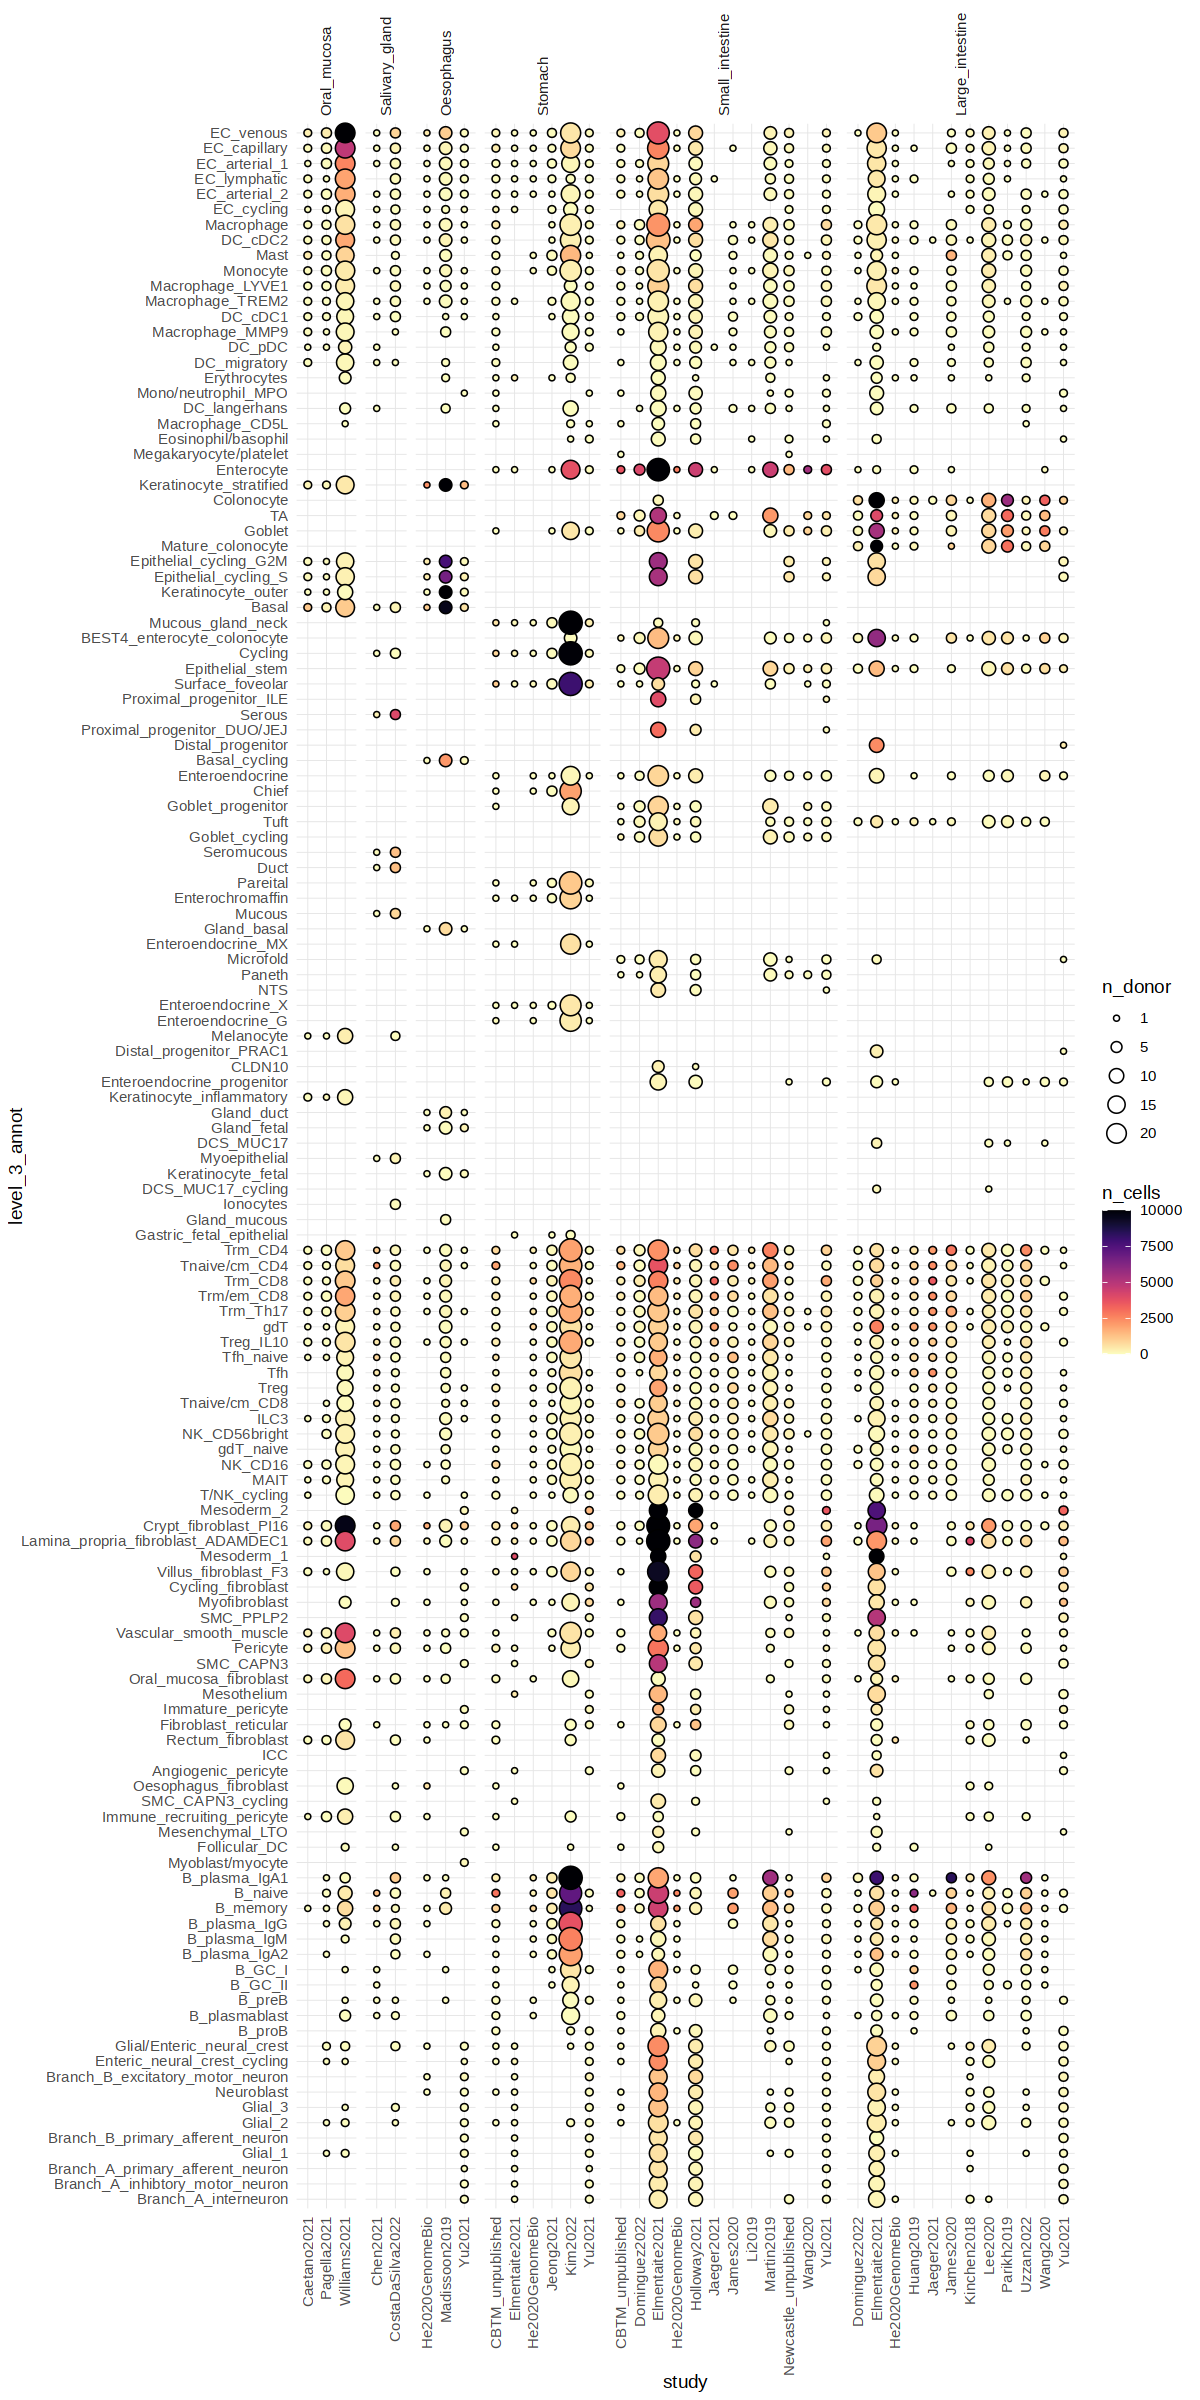

In [94]:
# Dotplot  of cell counts and donor counts per organ x study x disease
width = 10
height = 20.0
options(repr.plot.width=width, repr.plot.height=height)

# Copy
d = d_condition

organ_group_order = c(
    "Oral_mucosa",
    "Salivary_gland",
    "Oesophagus",
    "Stomach",
    "Small_intestine",
    "Large_intestine")

# Reorder organ levels
d$organ_groups = factor(
    d$organ_groups,
    levels=organ_group_order
)

d$level_3_annot = factor(
    d$level_3_annot,
    levels=cell_type_order
)

# dotplot
g = ggplot(d, aes(x=study, y=level_3_annot, size=n_donor, fill=n_cells)) +
    # Facets grid per disease condition, starting with controls 
    facet_grid(~organ_groups,
               scales="free_x",
               space="free_x",
               #switch="x"
              ) +  # free_x drops empty columns, free_x scales x dimensions to number of entries

    # Points
    geom_point(pch=21) +

    # Scales
    #scale_color_gradientn(colors=turbo(20)) +
    scale_fill_gradientn(colors=rev(magma(20)), limits=c(0, 10000), oob=scales::squish) +
    scale_size_area(max_size=6, breaks=c(1, 5, 10, 15, 20)) +
    
    # Style
    coord_cartesian(clip="off") +  # allow plotting outside bounding box, preventing clipping
    theme_minimal() +
    theme(
        # Vertical x labels
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),
        
        # Horizontal labels
        axis.text.y = element_text(
            #color=organ_colors
        ),
        
        # Vertical facets labels
        strip.text.x = element_text(angle=90, hjust=0),
        
        # Grid style
        panel.grid.major = element_line(
            color="grey90",
            linewidth=0.2
        ),
#         panel.grid.major.x = element_line(
#             color=alpha("grey80", 0.5),
#         ),
#         panel.grid.major.y = element_line(
#             color=alpha(organ_colors, 0.5),
#         ),
        panel.grid.minor = element_blank()  # no minor grid
    )
    

# # Shared organ color legend annotation across facets groups
# color_legend = ggplot(data.frame(id=1:length(organ_colors), group=names(organ_colors)), aes(y = id, x = 0, col=group)) +
#     geom_point(shape = 15, size = 5, show.legend = FALSE) + 
#     theme_classic() +
#     scale_color_manual(values=alpha(organ_colors, 1.0)) +
#     theme(
#         axis.title = element_blank(), axis.line = element_blank(), 
#         axis.text = element_blank(), axis.ticks = element_blank(), 
#         plot.margin = unit(c(0, 0, 0, 0), "cm"))

# g + annotation_custom(ggplotGrob(color_legend),
#     xmin = 0,
#     xmax = 0, 
#     ymin = -0.2,
#     ymax = length(organ_order) + 1
# )

g

ggsave("plots/megagut_metadata_visual_overview_healthy_cell_type_v3.pdf", width=width, height=height)

In [68]:
# Test if number of cells is consistent with cell metadata table
stopifnot(sum(d$n_cells) == nrow(meta))

## Epithelial cells across organs and studies

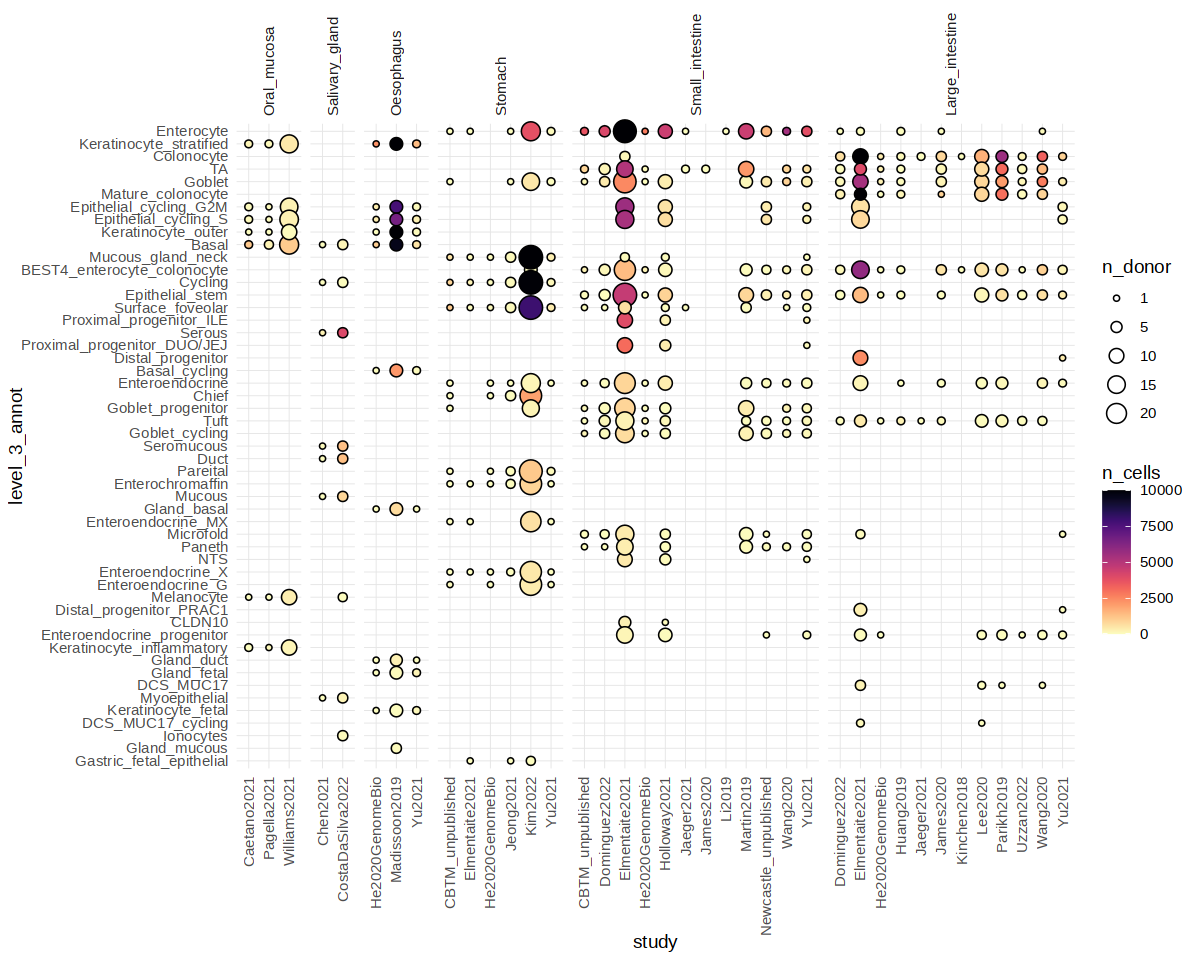

In [98]:
# Dotplot  of cell counts and donor counts per organ x study x disease
width = 10
height = 8.0
options(repr.plot.width=width, repr.plot.height=height)

# Copy
lineage = "Epithelial"

idx = d_condition$level_3_annot %in% cell_types[[lineage]]
d = d_condition[idx, ]

organ_group_order = c(
    "Oral_mucosa",
    "Salivary_gland",
    "Oesophagus",
    "Stomach",
    "Small_intestine",
    "Large_intestine")

# Reorder organ levels
d$organ_groups = factor(
    d$organ_groups,
    levels=organ_group_order
)

d$level_3_annot = factor(
    d$level_3_annot,
    levels=cell_type_order
)


# dotplot
g = ggplot(d, aes(x=study, y=level_3_annot, size=n_donor, fill=n_cells)) +
    # Facets grid per disease condition, starting with controls 
    facet_grid(~organ_groups,
               scales="free_x",
               space="free_x",
               #switch="x"
              ) +  # free_x drops empty columns, free_x scales x dimensions to number of entries

    # Points
    geom_point(pch=21) +

    # Scales
    #scale_color_gradientn(colors=turbo(20)) +
    scale_fill_gradientn(colors=rev(magma(20)), limits=c(0, 10000), oob=scales::squish) +
    scale_size_area(max_size=6, breaks=c(1, 5, 10, 15, 20)) +

    # Style
    coord_cartesian(clip="off") +  # allow plotting outside bounding box, preventing clipping
    theme_minimal() +
    theme(
        # Vertical x labels
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),

        # Horizontal labels
        axis.text.y = element_text(
            #color=organ_colors
        ),

        # Vertical facets labels
        strip.text.x = element_text(angle=90, hjust=0),

        # Grid style
        panel.grid.major = element_line(
            color="grey90",
            linewidth=0.2
        ),
#         panel.grid.major.x = element_line(
#             color=alpha("grey80", 0.5),
#         ),
#         panel.grid.major.y = element_line(
#             color=alpha(organ_colors, 0.5),
#         ),
        panel.grid.minor = element_blank()  # no minor grid
    )


# # Shared organ color legend annotation across facets groups
# color_legend = ggplot(data.frame(id=1:length(organ_colors), group=names(organ_colors)), aes(y = id, x = 0, col=group)) +
#     geom_point(shape = 15, size = 5, show.legend = FALSE) + 
#     theme_classic() +
#     scale_color_manual(values=alpha(organ_colors, 1.0)) +
#     theme(
#         axis.title = element_blank(), axis.line = element_blank(), 
#         axis.text = element_blank(), axis.ticks = element_blank(), 
#         plot.margin = unit(c(0, 0, 0, 0), "cm"))

# g + annotation_custom(ggplotGrob(color_legend),
#     xmin = 0,
#     xmax = 0, 
#     ymin = -0.2,
#     ymax = length(organ_order) + 1
# )

g

ggsave(paste0("plots/megagut_metadata_visual_overview_healthy_cell_type_v3_", lineage, ".pdf"), width=width, height=height)

## Endothelial cells

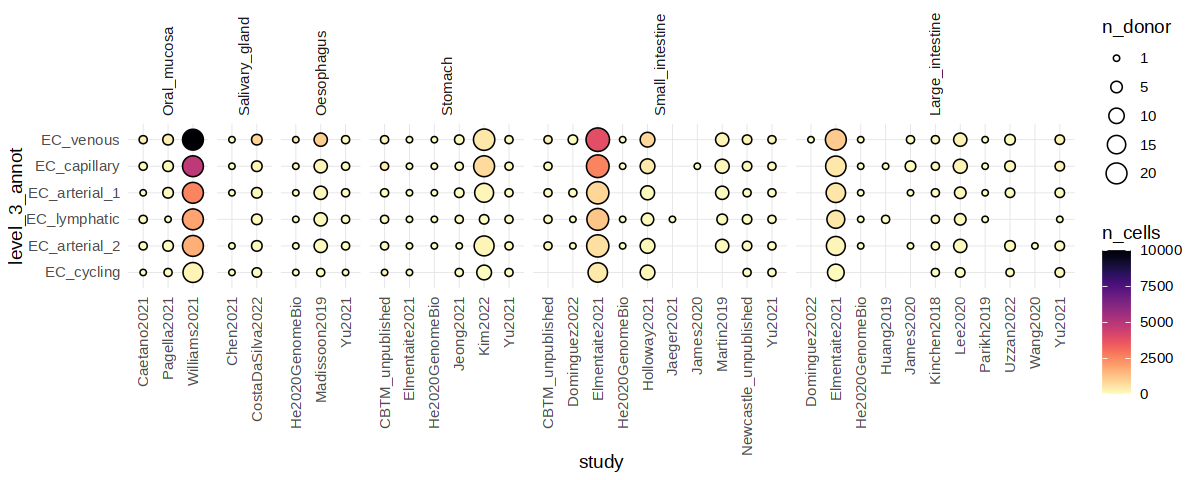

In [101]:
# Dotplot  of cell counts and donor counts per organ x study x disease
width = 10
height = 4.0
options(repr.plot.width=width, repr.plot.height=height)

# Copy
lineage = "Endothelial"

idx = d_condition$level_3_annot %in% cell_types[[lineage]]
d = d_condition[idx, ]

organ_group_order = c(
    "Oral_mucosa",
    "Salivary_gland",
    "Oesophagus",
    "Stomach",
    "Small_intestine",
    "Large_intestine")

# Reorder organ levels
d$organ_groups = factor(
    d$organ_groups,
    levels=organ_group_order
)

d$level_3_annot = factor(
    d$level_3_annot,
    levels=cell_type_order
)


# dotplot
g = ggplot(d, aes(x=study, y=level_3_annot, size=n_donor, fill=n_cells)) +
    # Facets grid per disease condition, starting with controls 
    facet_grid(~organ_groups,
               scales="free_x",
               space="free_x",
               #switch="x"
              ) +  # free_x drops empty columns, free_x scales x dimensions to number of entries

    # Points
    geom_point(pch=21) +

    # Scales
    #scale_color_gradientn(colors=turbo(20)) +
    scale_fill_gradientn(colors=rev(magma(20)), limits=c(0, 10000), oob=scales::squish) +
    scale_size_area(max_size=6, breaks=c(1, 5, 10, 15, 20)) +

    # Style
    coord_cartesian(clip="off") +  # allow plotting outside bounding box, preventing clipping
    theme_minimal() +
    theme(
        # Vertical x labels
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),

        # Horizontal labels
        axis.text.y = element_text(
            #color=organ_colors
        ),

        # Vertical facets labels
        strip.text.x = element_text(angle=90, hjust=0),

        # Grid style
        panel.grid.major = element_line(
            color="grey90",
            linewidth=0.2
        ),
#         panel.grid.major.x = element_line(
#             color=alpha("grey80", 0.5),
#         ),
#         panel.grid.major.y = element_line(
#             color=alpha(organ_colors, 0.5),
#         ),
        panel.grid.minor = element_blank()  # no minor grid
    )


# # Shared organ color legend annotation across facets groups
# color_legend = ggplot(data.frame(id=1:length(organ_colors), group=names(organ_colors)), aes(y = id, x = 0, col=group)) +
#     geom_point(shape = 15, size = 5, show.legend = FALSE) + 
#     theme_classic() +
#     scale_color_manual(values=alpha(organ_colors, 1.0)) +
#     theme(
#         axis.title = element_blank(), axis.line = element_blank(), 
#         axis.text = element_blank(), axis.ticks = element_blank(), 
#         plot.margin = unit(c(0, 0, 0, 0), "cm"))

# g + annotation_custom(ggplotGrob(color_legend),
#     xmin = 0,
#     xmax = 0, 
#     ymin = -0.2,
#     ymax = length(organ_order) + 1
# )

g

ggsave(paste0("plots/megagut_metadata_visual_overview_healthy_cell_type_v3_", lineage, ".pdf"), width=width, height=height)

## Non-epithelial cells

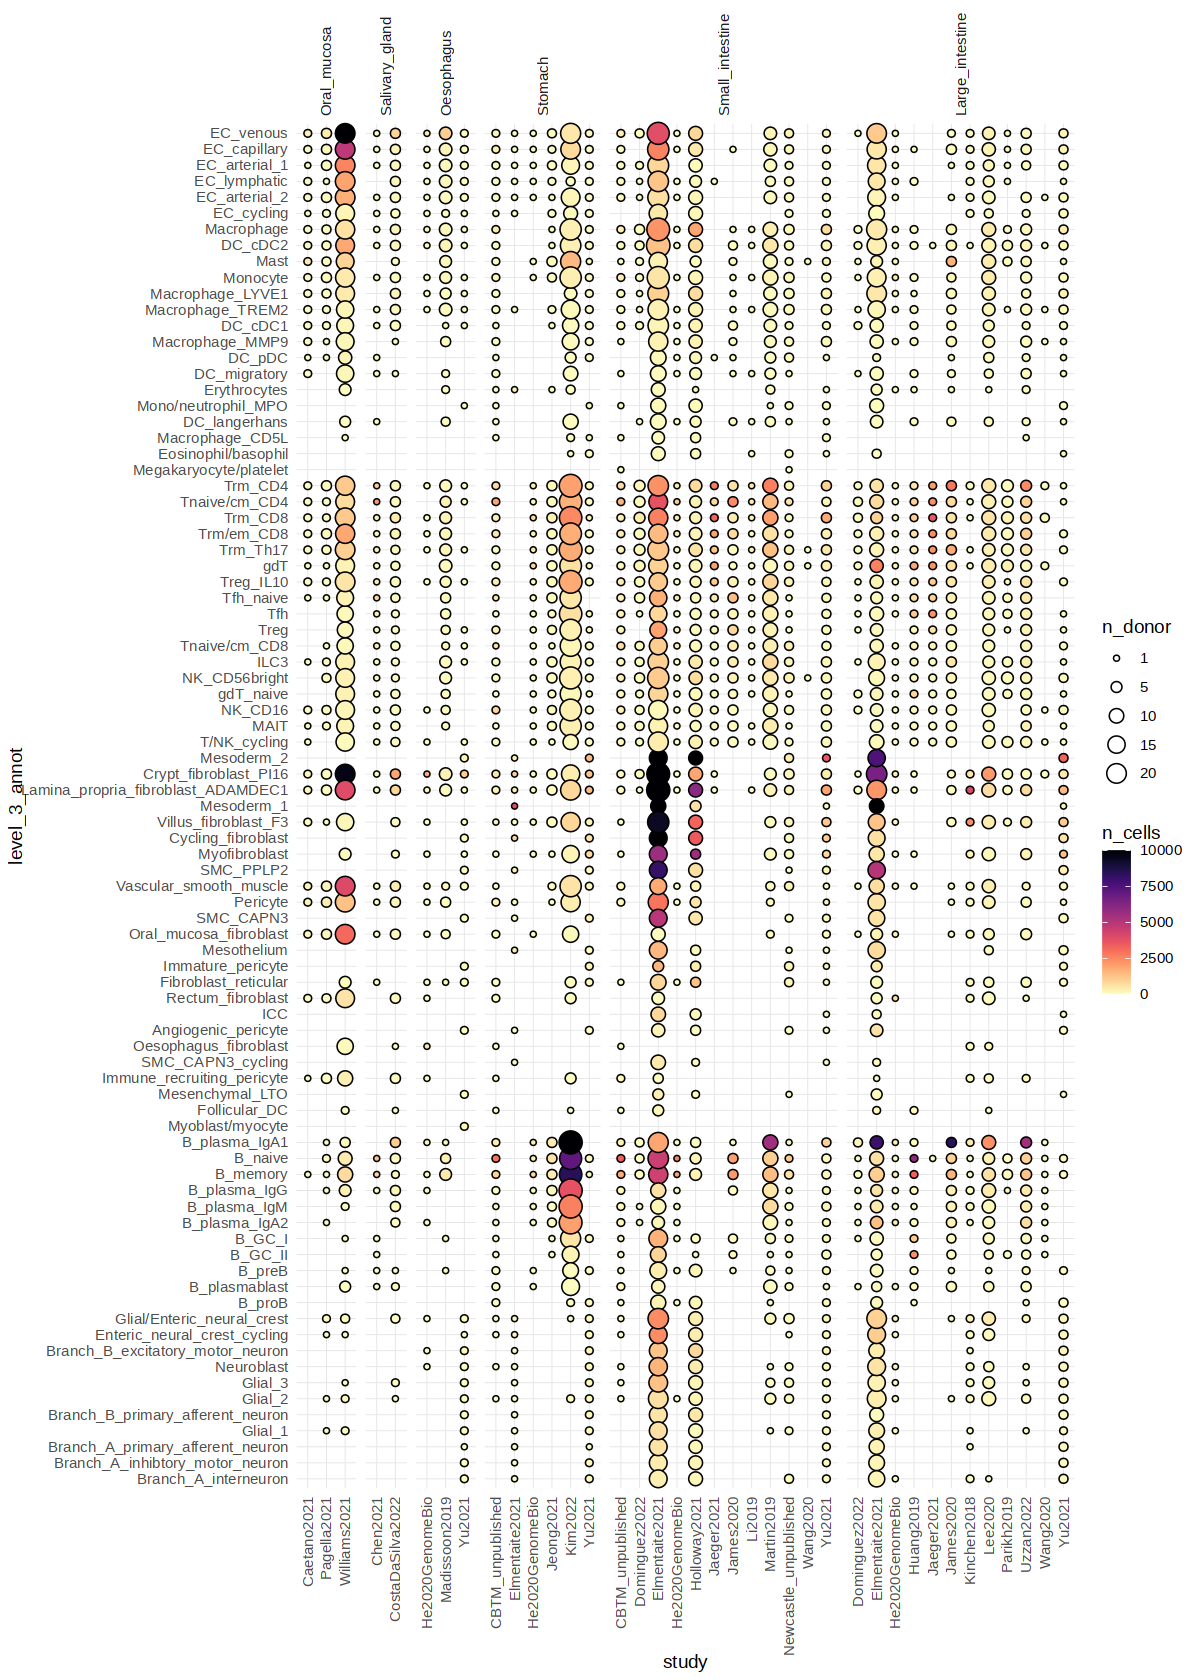

In [111]:
# Dotplot  of cell counts and donor counts per organ x study x disease
width = 10
height = 14.0
options(repr.plot.width=width, repr.plot.height=height)

# Copy
lineage = "Epithelial"

idx = !d_condition$level_3_annot %in% cell_types[[lineage]]
d = d_condition[idx, ]

organ_group_order = c(
    "Oral_mucosa",
    "Salivary_gland",
    "Oesophagus",
    "Stomach",
    "Small_intestine",
    "Large_intestine")

# Reorder organ levels
d$organ_groups = factor(
    d$organ_groups,
    levels=organ_group_order
)

d$level_3_annot = factor(
    d$level_3_annot,
    levels=cell_type_order
)


# dotplot
g = ggplot(d, aes(x=study, y=level_3_annot, size=n_donor, fill=n_cells)) +
    # Facets grid per disease condition, starting with controls 
    facet_grid(~organ_groups,
               scales="free_x",
               space="free_x",
               #switch="x"
              ) +  # free_x drops empty columns, free_x scales x dimensions to number of entries

    # Points
    geom_point(pch=21) +

    # Scales
    #scale_color_gradientn(colors=turbo(20)) +
    scale_fill_gradientn(colors=rev(magma(20)), limits=c(0, 10000), oob=scales::squish) +
    scale_size_area(max_size=6, breaks=c(1, 5, 10, 15, 20)) +

    # Style
    coord_cartesian(clip="off") +  # allow plotting outside bounding box, preventing clipping
    theme_minimal() +
    theme(
        # Vertical x labels
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1),

        # Horizontal labels
        axis.text.y = element_text(
            #color=organ_colors
        ),

        # Vertical facets labels
        strip.text.x = element_text(angle=90, hjust=0),

        # Grid style
        panel.grid.major = element_line(
            color="grey90",
            linewidth=0.2
        ),
#         panel.grid.major.x = element_line(
#             color=alpha("grey80", 0.5),
#         ),
#         panel.grid.major.y = element_line(
#             color=alpha(organ_colors, 0.5),
#         ),
        panel.grid.minor = element_blank()  # no minor grid
    )


# # Shared organ color legend annotation across facets groups
# color_legend = ggplot(data.frame(id=1:length(organ_colors), group=names(organ_colors)), aes(y = id, x = 0, col=group)) +
#     geom_point(shape = 15, size = 5, show.legend = FALSE) + 
#     theme_classic() +
#     scale_color_manual(values=alpha(organ_colors, 1.0)) +
#     theme(
#         axis.title = element_blank(), axis.line = element_blank(), 
#         axis.text = element_blank(), axis.ticks = element_blank(), 
#         plot.margin = unit(c(0, 0, 0, 0), "cm"))

# g + annotation_custom(ggplotGrob(color_legend),
#     xmin = 0,
#     xmax = 0, 
#     ymin = -0.2,
#     ymax = length(organ_order) + 1
# )

g

ggsave(paste0("plots/megagut_metadata_visual_overview_healthy_cell_type_v3_not", lineage, ".pdf"), width=width, height=height)